Setup

In [ ]:
import sys
sys.path.append('Libraries/')
import pclpy
import cv2
import glob
import os
import numpy as np
import pdal
import segTree
import Visualization
import Utils
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

#Utils
def tic():
    global timestart
    timestart = time.perf_counter()
    
def toc():
    global timestart
    return time.perf_counter()-timestart

In [ ]:
verticalityThresh = 0.04
NonNANcurvatureThresh = 0.06

lowstems_Height = 5
cutstems_Height = 5

EvaluationMetrics = {}

EvaluationMetrics['Completeness'] = []
EvaluationMetrics['Correctness'] = []
EvaluationMetrics['Mean_AoD'] = []
EvaluationMetrics['Diameter_RMSE'] = []
EvaluationMetrics['Diameter_bias'] = []
EvaluationMetrics['Location_RMSE'] = []
EvaluationMetrics['Location_bias'] = []

EvaluationMetrics['Relative_Diameter_RMSE'] = []
EvaluationMetrics['Relative_Diameter_bias'] = []
EvaluationMetrics['Relative_Location_RMSE'] = []
EvaluationMetrics['Relative_Location_bias'] = []

EvaluationMetrics['n_ref'] = []
EvaluationMetrics['n_match'] = []
EvaluationMetrics['n_extr'] = []
EvaluationMetrics['location_y'] = []
EvaluationMetrics['diameter_y'] = []

In [4]:
for number in range(1,7):
    print('load point cloud ', number)
    PointCloud = pclpy.pcl.PointCloud.PointXYZ()
    pclpy.pcl.io.loadPCDFile('D:/Documentos/ParaAutonomia/Python/Proyecto/Data/NistClouds/downsampledlesscloudEURO' + str(number) + '.pcd',PointCloud)

    print('extract ground')
    AllGround = []
    AllNonGround = []  
    Nogroundpoints,ground = segTree.FloorRemove(PointCloud)

    NongroundCloud = pclpy.pcl.PointCloud.PointXYZ(Nogroundpoints)
    GroundCloud = pclpy.pcl.PointCloud.PointXYZ(ground)

    print('Get point normals for filtering')

    Ksearch = 0.08
    normals = segTree.ExtractNormals(NongroundCloud.xyz, Ksearch)


    nanmask = np.bitwise_not(np.isnan(normals.normals[:,0]))
    NonNANpoints = NongroundCloud.xyz[nanmask]
    NonNANnormals = normals.normals[nanmask]
    NonNANcurvature = normals.curvature[nanmask]
    verticality = np.dot(NonNANnormals,[[0],[0],[1]])
    mask = (verticality < verticalityThresh) & (-verticalityThresh < verticality)  #0.1
    maskC = (NonNANcurvature < NonNANcurvatureThresh)## 0.12
    Fmask = mask.ravel() & maskC.ravel()

    onlyhorizontalpoints = NonNANpoints[Fmask]
    onlyhorizontalnormals = NonNANnormals[Fmask]


    cluster_list = segTree.EucladeanClusterExtract(onlyhorizontalpoints, tol=0.1, minc=40, maxc=6000000)

    print('Group stem segments')
    GroupStems = []

    bufferStems = cluster_list.copy()
    for n,p in enumerate(cluster_list):
        Centroid = np.mean(p, axis = 0)
        _, S,vT = np.linalg.svd(p-Centroid)
        strieghtness = S[0]/(S[0]+S[1]+S[2])

        clustersDICT = {}
        clustersDICT['cloud'] = p
        clustersDICT['strieghtness'] = strieghtness
        clustersDICT['center'] = Centroid
        clustersDICT['direction'] = vT
        GroupStems.append(clustersDICT)

    bufferStems = [i['cloud'] for i in GroupStems]
    for treenumber1 in reversed(range(0,len(bufferStems))):
        for treenumber2 in reversed(range(0,treenumber1-1)):
            center1 = GroupStems[treenumber1]['center']
            center2 = GroupStems[treenumber2]['center']
            angle1 = GroupStems[treenumber1]['direction'][0]
            angle2 = GroupStems[treenumber2]['direction'][0]
            dist1 = Utils.DistPoint2Line(center2,angle1+center1,center1)
            dist2 = Utils.DistPoint2Line(center1,angle2+center2,center2)
            if (dist1<0.4) | (dist2<0.4):
                bufferStems[treenumber2] = np.vstack([bufferStems[treenumber2],bufferStems.pop(treenumber1)])
                break

    pointpart = GroundCloud.xyz
    #groundseg = groundCloud.xyz[center]
    A = np.c_[np.ones(pointpart.shape[0]), pointpart[:,:2], np.prod(pointpart[:,:2], axis=1), pointpart[:,:2]**2]
    C,_,_,_ = np.linalg.lstsq(A, pointpart[:,2])
    #Corners.PCL3dpaint(cluster_list)

    StemsWithGround = []
    for i in bufferStems:
        center = np.mean(i,0)
        X,Y = center[:2]
        Z = np.dot(np.c_[np.ones(X.shape), X, Y, X*Y, X**2, Y**2], C)
        StemsWithGround.append([i,[X,Y,Z[0]]])

    #lowStems = [i for i in StemsWithGround if np.min(i[0],axis=0)[2] < (3 + i[1][2])]
    #cutstems = [i[i[:,2]<(3+np.min(i[:,2]))] for i in lowStems]

    lowStems = [i for i in StemsWithGround if np.min(i[0],axis=0)[2] < (lowstems_Height + i[1][2])]
    cutstems = [[i[0][i[0][:,2]<(cutstems_Height + i[1][2])],i[1]] for i in lowStems]

    finalstems = []
    stemcyls = []
    rech = []
    for p in cutstems:
        segpoints = p[0]
        indices, model = segTree.segment_normals(segpoints, searchRadius=0.1, model=pclpy.pcl.sample_consensus.SACMODEL_CYLINDER, method=pclpy.pcl.sample_consensus.SAC_RANSAC, normalweight=0.01, miter=10000, distance=0.06, rlim=[0,0.4])
        if len(indices)>0:
            if abs(np.dot(model[3:6],[0,0,1])/np.linalg.norm(model[3:6])) > 0.5:
                newmodel = np.array(model)
                Z = 1.3 + p[1][2]
                Y = model[1] + model[4] * (Z - model[2]) / model[5]
                X = model[0] + model[3] * (Z - model[2]) / model[5]
                newmodel[0:3] = np.array([X,Y,Z])
                newmodel[3:6] = Utils.similarize(newmodel[3:6],[0,0,1])
                finalstems.append({'tree':segpoints[indices],'model':newmodel})
                stemcyls.append(Utils.makecylinder(model=newmodel,length=7,dense=60))
            else:
                rech.append(segpoints)
        else:
            rech.append(segpoints)



    #####################################################
    print('Get ground truth')
    treedata = pd.read_csv('D:/Documentos/ParaAutonomia/Python/Proyecto/Data/EuroSDR_DataRelease/EuroSDR_DataRelease/TLS_Benchmarking_Plot_' + str(number) + '_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
    Xcor,Ycor,diam = treedata.iloc[0,[0,1,3]]
    surtreesL1 = [Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20)]
    Zcor = 0
    TreeDict = [np.array([Xcor,Ycor,diam])]
    for i,rows in treedata.iloc[1:].iterrows():
        Xcor,Ycor,diam = rows.iloc[[0,1,3]]
        if not np.any(np.isnan([Xcor,Ycor,diam])):
            surtreesL1.append(Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=10))
            TreeDict.append(np.array([Xcor,Ycor,diam]))
    surtrees1 = [p for i in surtreesL1 for p in i]
    surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

                #DataBase
    #Found trees
    #Hungarian Algorithm assignment
    CostMat = np.ones([len(TreeDict),len(stemcyls)])
    for X,datatree in enumerate(TreeDict):
        for Y,foundtree in enumerate(finalstems):
            CostMat[X,Y] = np.linalg.norm([datatree[0:2]-foundtree['model'][0:2]])

    dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

    #Get metrics
    locationerror = []
    correctlocationerror = []
    diametererror = []
    cloudmatch = []
    for i,j in zip(dataindex, foundindex):
        locationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
        if locationerror[-1]<0.4:
            diametererror.append(abs(finalstems[j]['model'][6]*2-TreeDict[i][2]))        
            correctlocationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
        cloudmatch.append(np.vstack([surtreesL1[i],finalstems[j]['tree'],stemcyls[j]]))
        
    EvaluationMetrics['n_ref'].append(len(TreeDict))
    EvaluationMetrics['n_match'].append(len(diametererror))
    EvaluationMetrics['n_extr'].append(len(locationerror) - EvaluationMetrics['n_match'][-1])
    EvaluationMetrics['location_y'].append(np.linalg.norm(np.sum(np.array([TreeDict[i][0:2] for i in dataindex]),axis=0)/len(dataindex)))
    EvaluationMetrics['diameter_y'].append(np.sum(np.array([finalstems[i]['model'][6]*2 for i in foundindex]),axis=0)/len(foundindex))

    EvaluationMetrics['Completeness'].append(EvaluationMetrics['n_match'][-1]/EvaluationMetrics['n_ref'][-1])
    EvaluationMetrics['Correctness'].append(EvaluationMetrics['n_match'][-1]/(EvaluationMetrics['n_extr'][-1]+EvaluationMetrics['n_match'][-1]))
    EvaluationMetrics['Mean_AoD'].append(2*EvaluationMetrics['n_match'][-1]/(EvaluationMetrics['n_ref'][-1]+EvaluationMetrics['n_extr'][-1]))
    EvaluationMetrics['Diameter_RMSE'].append(np.sqrt(np.sum(np.array(diametererror)**2)/len(diametererror)))
    EvaluationMetrics['Diameter_bias'].append(np.sum(np.array(diametererror))/len(diametererror))
    EvaluationMetrics['Location_RMSE'].append(np.sqrt(np.sum(np.array(correctlocationerror)**2)/len(correctlocationerror)))
    EvaluationMetrics['Location_bias'].append(np.sum(np.array(correctlocationerror))/len(correctlocationerror))

    EvaluationMetrics['Relative_Diameter_RMSE'].append(EvaluationMetrics['Diameter_RMSE'][-1]/EvaluationMetrics['diameter_y'][-1])
    EvaluationMetrics['Relative_Diameter_bias'].append(EvaluationMetrics['Diameter_bias'][-1]/EvaluationMetrics['diameter_y'][-1])
    EvaluationMetrics['Relative_Location_RMSE'].append(EvaluationMetrics['Location_RMSE'][-1]/EvaluationMetrics['location_y'][-1])
    EvaluationMetrics['Relative_Location_bias'].append(EvaluationMetrics['Location_bias'][-1]/EvaluationMetrics['location_y'][-1])

load point cloud  1
extract ground
Get point normals for filtering
Group stem segments


C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Get ground truth
load point cloud  2
extract ground
Get point normals for filtering
Group stem segments
Get ground truth
load point cloud  3
extract ground
Get point normals for filtering


KeyboardInterrupt: 

In [36]:
Methods = ['CAF','TUDelft','FGI','IntraIGN','RADI','NJU','Shinshu','SLU','TUZVO','TUWien','RILOG','TreeMetrics','UofL','WHU']
CompletenessEasy = [88, 66, 94, 84, 74, 88, 89, 94, 87, 82, 96, 36, 69, 89]
CompletenessMedium = [75, 49, 88, 65, 59, 81, 78, 88, 74, 68, 87, 27, 58, 80]
CompletenessHard = [44, 16, 66, 27, 25, 45, 46, 64, 39, 39, 63, 18, 37, 52]

CorrectnessEasy = [96, 69, 90, 97, 94, 44, 77, 86, 94, 95, 77, 99, 86, 86]
CorrectnessMedium = [99, 61, 89, 98, 97, 44, 76, 91, 95, 96, 89, 99, 91, 88]
CorrectnessHard = [99, 41, 93, 97, 97, 70, 74, 91, 95, 97, 88, 99, 91, 90]

StemRMSEEasy = [2.2, 15.4, 2.8, 1.2, 3.2, 13.2, 5.2, 2.0, 2.0, 1.6, 3.2, 3.0, 8.8, 5.8]
StemRMSEMedium = [3.2, 18.2, 3.0, 4.0, 4.8, 20.0, 8.0, 4.2, 3.6, 2.6, 6.4, 2.6, 11.6, 8.2]
StemRMSEHard = [4.0, 27.3, 6.4, 7.0, 8.0, 20.0, 12.0, 6.6, 8.2, 4.8, 11.2, 2.4, 14.4, 12.0]

DBHRMSEEasy = [2.0, 12.8, 1.4, 1.6, 2.0, 21.0, 4.8, 1.8, 2.2, 1.4, 8.6, 1.2, 6.2, 7.2]
DBHRMSEMedium = [2.2, 12.2, 1.8, 3.4, 4.0, 24.0, 8.0, 3.2, 3.4, 1.6, 11.0, 2.0, 8.4, 9.6]
DBHRMSEHard = [1.8, 17.4, 2.0, 30.0, 7.4, 25.0, 9.4, 3.0, 3.6, 1.2, 17.4, 2.4, 9.4, 12.4]

In [37]:
BenchmarkMetrics = {}
BenchmarkMetrics['Completeness'] = [CompletenessEasy,CompletenessMedium,CompletenessHard]
BenchmarkMetrics['Correctness'] = [CorrectnessEasy,CorrectnessMedium,CorrectnessHard]
BenchmarkMetrics['Location_RMSE'] = [StemRMSEEasy,StemRMSEMedium,StemRMSEHard]
BenchmarkMetrics['Diameter_RMSE'] = [DBHRMSEEasy,DBHRMSEMedium,DBHRMSEHard]

In [38]:
fileFGI = np.load('resultsFGI.npz')

In [39]:
alldata = ['n_ref', 'n_match', 'n_extr', 'Completeness', 'Correctness', 'Diameter_RMSE', 'Diameter_bias', 
           'Location_RMSE', 'Location_bias', 'Relative_Diameter_RMSE', 'Relative_Diameter_bias', 'Relative_Location_RMSE', 'Relative_Location_bias']

EvaluationMetrics = {}
for i in alldata:
    EvaluationMetrics[i] = fileFGI[i]

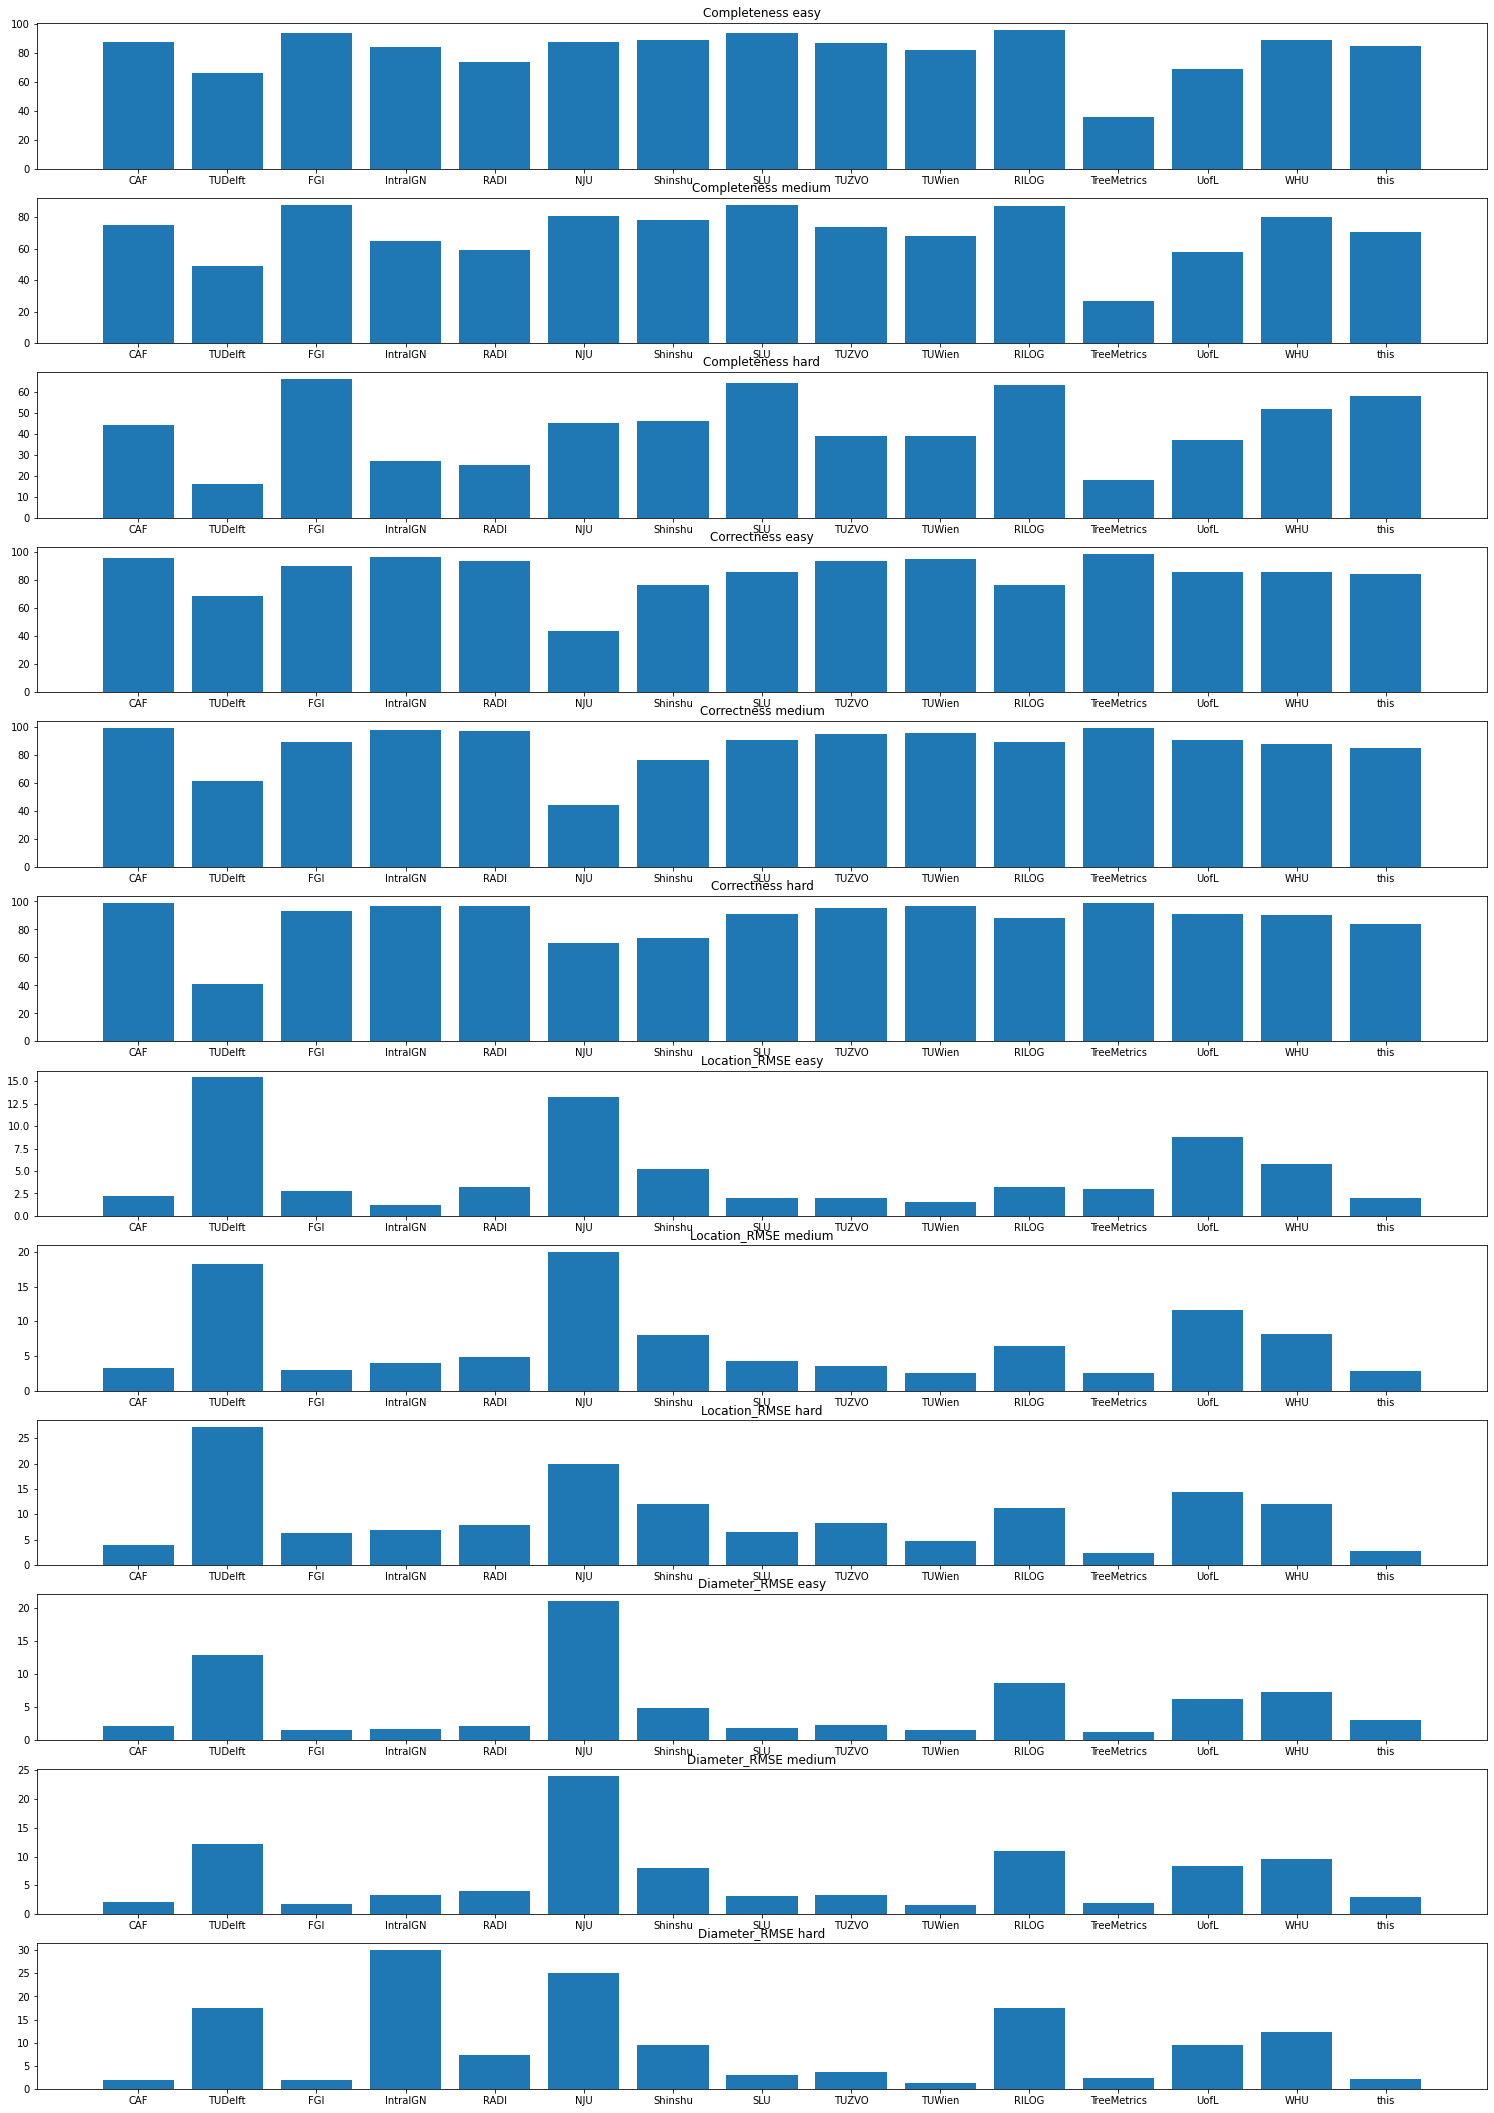

In [42]:
alldata = ['Completeness', 'Correctness', 'Location_RMSE', 'Diameter_RMSE']
dificulties = ['easy', 'medium', 'hard']
plt.figure(figsize=(26,38))
for n,i in enumerate(alldata):
    for n2 in range(3):
        plt.subplot(12,1,n*3+n2+1)
        plt.title(i + ' ' + dificulties[n2])
        mine = np.mean(EvaluationMetrics[i][slice(n2,n2+2)])*100
         
        #plt.bar(np.arange(len(BenchmarkMetrics[i][n2])+1),BenchmarkMetrics[i][n2]+[mine])
        plt.bar(Methods + ['this'],BenchmarkMetrics[i][n2]+[mine])

In [ ]:
if True:
    np.savez('resultsFGI',
             n_ref = n_ref,
             n_match = n_match,
             n_extr =n_extr,
             location_y = location_y,
             diameter_y = diameter_y, 
             Completeness = Completeness,
                    Correctness = Correctness,
                    Mean_AoD = Mean_AoD,
                    Diameter_RMSE = Diameter_RMSE,
                    Diameter_bias = Diameter_bias,
                    Location_RMSE = Location_RMSE,
                    Location_bias = Location_bias,
                    Relative_Diameter_RMSE = Relative_Diameter_RMSE,
                    Relative_Diameter_bias = Relative_Diameter_bias,
                    Relative_Location_RMSE = Relative_Location_RMSE,
                    Relative_Location_bias = Relative_Location_bias)

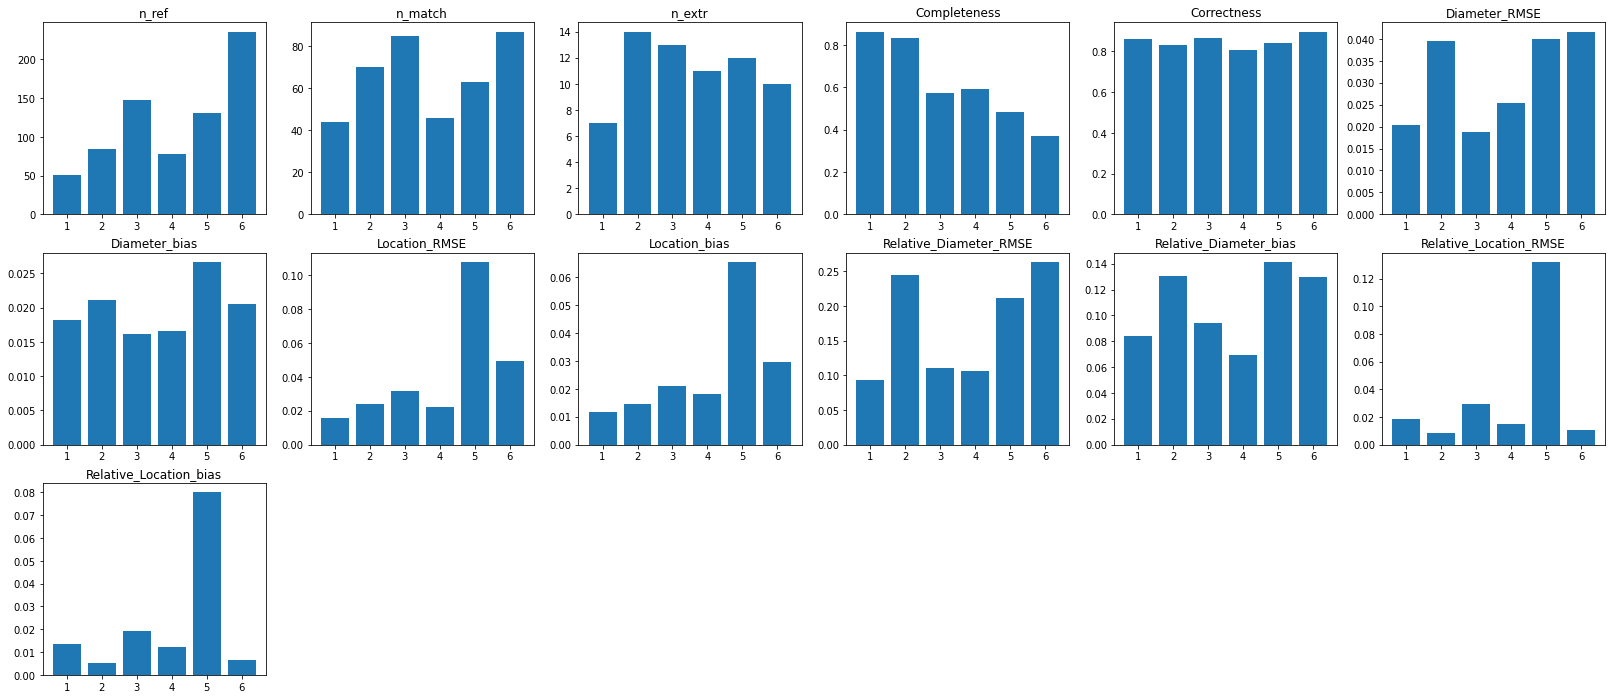

In [15]:
plt.figure(figsize=(28,12))
for n,i in enumerate(alldata):
    plt.subplot(3,6,n+1)
    plt.title(i)
    plt.bar(np.array([1,2,3,4,5,6]),EvaluationMetrics[i])